<a href="https://colab.research.google.com/github/alexganea7/Noise-reduction/blob/main/Gaussian_noise_reduction_from_audio_signals_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q opencv-python numpy matplotlib scikit-learn tqdm torch tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import soundfile as sf
import os
from tqdm import tqdm
import librosa
import scipy
import re


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset folosit "clean_test" din https://github.com/microsoft/MS-SNSD arhivat pe drive in folderul videos sub denumirea de dataset
zip_dataset = '/content/drive/MyDrive/videos/dataset.zip'
!unzip -q {zip_dataset}

In [ ]:
path = './dataset'
audio = path+'/audio'
FIXED_LENGTH = 2 * 16000
HOP_SIZE = 128
FRAME_SIZE = 512

In [ ]:
audioFiles = os.listdir(audio)
audioFiles = [audio +'/' + x for x in audioFiles]
print(audioFiles[0])

./dataset/audio/p283_096.wav


## Preprocessing

In [ ]:
def processAudio(file):
    raw_signal, fs = sf.read(file)
    raw_signal = get_fix_length(raw_signal)

    stft = librosa.stft(raw_signal, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
    stft = stft / 10.
    clean_stft = np.stack((np.real(stft), np.imag(stft)), dtype=np.float32)

    noisy_raw_signal = noise_augmentation(raw_signal)
    stft = librosa.stft(noisy_raw_signal, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
    stft = stft / 10.
    noisy_stft = np.stack((np.real(stft), np.imag(stft)), dtype=np.float32)
    noisy_stft = noisy_stft[:,:-2,:]
    noisy_stft = np.concatenate((noisy_stft, np.zeros((2,255,4))), dtype=np.float32, axis=-1)
    return noisy_stft, clean_stft

## Data augmentation

In [ ]:
def noise_augmentation(raw_signal):
    target_snr_db = np.random.randint(10, 15)
    sig_avg_watts = np.mean(raw_signal ** 2)
    sig_avg_db = 10 * np.log10(sig_avg_watts + 1e-8)
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), raw_signal.shape)
    raw_signal = raw_signal + noise
    return raw_signal


In [ ]:
def get_fix_length(raw_signal):
    if len(raw_signal) == FIXED_LENGTH:
        return raw_signal
    elif len(raw_signal) < FIXED_LENGTH:
        padding = np.zeros(FIXED_LENGTH - len(raw_signal))
        fixed_signal = np.concatenate((raw_signal, padding))
        return fixed_signal
    else:
        fixed_signal = raw_signal[:FIXED_LENGTH]
        return fixed_signal

In [75]:
data = []
for file in tqdm(range(5000)):
    data.append(processAudio(audioFiles[file]))

100%|██████████| 5000/5000 [00:41<00:00, 120.16it/s]


In [ ]:
if not os.path.exists('results'):
    os.makedirs('results')

# Model 1

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.n_channels = 8

        ### Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, self.n_channels, 3, stride=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(self.n_channels),

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.n_channels, 2 * self.n_channels, 3, stride=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(2 * self.n_channels),


        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2 * self.n_channels, 4 * self.n_channels, 3, stride=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(4 * self.n_channels),

        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(4 * self.n_channels, 8 * self.n_channels, 3, stride=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(8 * self.n_channels),

        )

        ### Decoder
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(8 * self.n_channels, 4*self.n_channels, 3, 2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(4*self.n_channels),

        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(4*self.n_channels, 2*self.n_channels, 3, 2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(2*self.n_channels)

        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(2*self.n_channels, self.n_channels, 3, 2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(self.n_channels)

        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(self.n_channels, 2, 3, 2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(2)

        )

        self.convout = nn.Sequential(
            nn.Conv2d(2, 2, 3, 1, 1),
            nn.Sigmoid()
            #sigmoid pt mask
        )

    def forward(self, x):

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.deconv1(x4) + x3
        x6 = self.deconv2(x5) + x2
        x7 = self.deconv3(x6) + x1
        x8 = self.deconv4(x7)
        mask = self.convout(x8)
        y = mask * x
        return y


In [ ]:
import torchsummary
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(DEVICE)
torchsummary.summary(model, data[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 127, 127]             152
         LeakyReLU-2          [-1, 8, 127, 127]               0
       BatchNorm2d-3          [-1, 8, 127, 127]              16
            Conv2d-4           [-1, 16, 63, 63]           1,168
         LeakyReLU-5           [-1, 16, 63, 63]               0
       BatchNorm2d-6           [-1, 16, 63, 63]              32
            Conv2d-7           [-1, 32, 31, 31]           4,640
         LeakyReLU-8           [-1, 32, 31, 31]               0
       BatchNorm2d-9           [-1, 32, 31, 31]              64
           Conv2d-10           [-1, 64, 15, 15]          18,496
        LeakyReLU-11           [-1, 64, 15, 15]               0
      BatchNorm2d-12           [-1, 64, 15, 15]             128
  ConvTranspose2d-13           [-1, 32, 31, 31]          18,464
        LeakyReLU-14           [-1, 32,

In [ ]:
def train():
    BATCH_SIZE = 32
    EPOCHS = 50
    LR = 1e-3
    BAR_FORMAT = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"model running on device: {DEVICE}\n")
    split = int(0.8 * len(data))
    train_data = data[:split]
    test_data = data[split:]

    train_data = [(noisy_stft, clean_stft) for (noisy_stft, clean_stft) in train_data]
    test_data = [(noisy_stft, clean_stft) for (noisy_stft, clean_stft) in test_data]
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


    model = Network().to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    history = 9999
    saved_epoch = -1

    for i in range(EPOCHS):
            print(f"+++++++++++++RUNNING EPOCH: {i} ++++++++++++++++")

            print("=============TRAINING===============")

            model.train().to(DEVICE)
            for x, y in tqdm(train_loader, bar_format=BAR_FORMAT):
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)
                pred = pred.to(DEVICE)
                pred = torch.concatenate((pred, torch.zeros(pred.shape[0], pred.shape[1], 2 ,pred.shape[3], device=DEVICE)), dim=-2)
                pred = pred[:,:,:,:-4]
                loss = loss_fn(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                mse = float(loss)
                mae = (y - pred).abs().mean()
            mse_train.append(mse)
            mae_train.append(mae)

            print(f"MSE TRAIN: =============={mse}")
            print(f"MAE TRAIN: =============={mae}")
            # print("predicted")
            print(" ")

            print("=============TESTING===============")

            model.eval().to(device=DEVICE)

            for x, y in tqdm(test_loader, bar_format=BAR_FORMAT):
                x, y = x.to(DEVICE), y.to(DEVICE)
                with torch.no_grad():
                    pred = model(x)
                    pred = pred.to(DEVICE)
                    pred = torch.concatenate((pred, torch.zeros(pred.shape[0], pred.shape[1], 2 ,pred.shape[3], device=DEVICE)), dim=-2)
                    pred = pred[:,:,:,:-4]
                    loss = loss_fn(pred, y)
                    x = torch.concatenate((x, torch.zeros(x.shape[0], x.shape[1], 2 ,x.shape[3], device=DEVICE)), dim=-2)
                    x = x[:,:,:,:-4]
                    mse = float(loss)
                    mae = (y - pred).abs().mean()

                if mae < history:
                    history = mae
                    saved_epoch = i

                    # print(f"model with {mae} mae saved at epoch {i}")

                    y = y.detach().cpu().numpy()[0,:,:,:]
                    pred = pred.detach().cpu().numpy()[0,:,:,:]
                    x = x.detach().cpu().numpy()[0,:,:,:]

                    y = y[0] + y[1]*1j
                    x = x[0] + x[1]*1j
                    pred = pred[0] + pred[1]*1j

                    clean = librosa.istft(y, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
                    noisy = librosa.istft(x, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
                    enhanced = librosa.istft(pred, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)

                    scipy.io.wavfile.write("results/clean.wav", 16000, 10 * clean)
                    scipy.io.wavfile.write("results/noisy.wav", 16000, 10 * noisy)
                    scipy.io.wavfile.write("results/enhanced.wav", 16000,10 *  enhanced)

                    torch.save(model.state_dict(), "saved_model.pt")
            mse_test.append(mse)
            mae_test.append(mae)

In [ ]:
mse_train = []
mse_test = []
mae_train = []
mae_test = []
train()

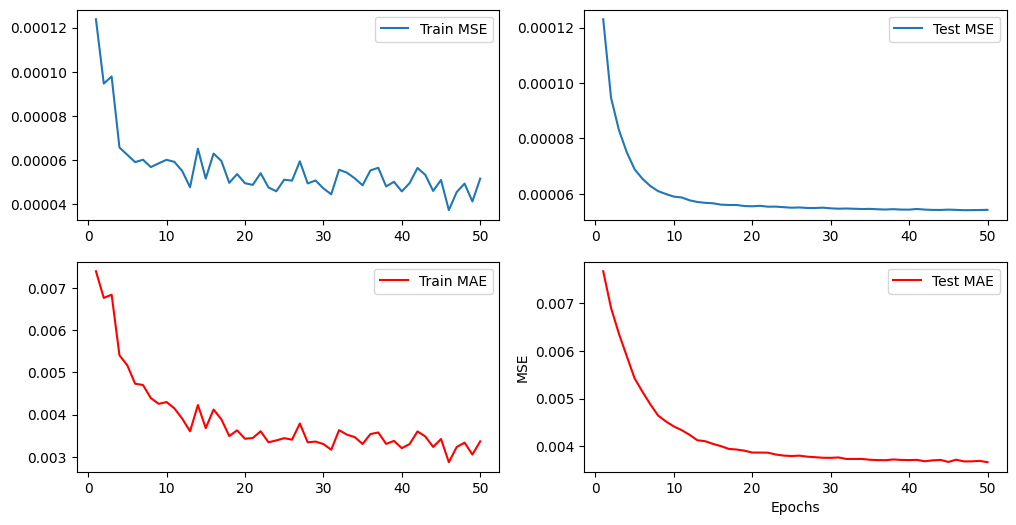

In [ ]:
EPOCHS = 50
BATCH_SIZE = 25
if(type(mae_test[1])!=type(0.)):
  mae_test = [tensor.item() for tensor in mae_test]
  mae_train = [tensor.item() for tensor in mae_train]
fig, ax = plt.subplots(2, 2, figsize = (12, 6))
ax[0][0].plot(range(1, EPOCHS + 1), mse_train, label='Train MSE')
ax[0][0].legend()
ax[0][1].plot(range(1, EPOCHS + 1), mse_test, label='Test MSE')
ax[0][1].legend()
ax[1][0].plot(range(1, EPOCHS + 1), mae_train, label='Train MAE', color = 'r')
ax[1][0].legend()
ax[1][1].plot(range(1, EPOCHS + 1), mae_test, label='Test MAE', color = 'r')
ax[1][1].legend()



plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
fig.savefig(f'results/erori.png')



In [ ]:
# load model salvat pentru a face teste pe diferite audio

model = Network()
model.load_state_dict(torch.load("saved_model.pt"))
model.eval()

FIXED_LENGTH = 2 * 16000

def process_audio(input_file="", output_file="", signal = []):
    if(input_file):
        print(input_file)
        signal, fs = sf.read(input_file)
        print(sf.info(input_file).channels)

    signal = get_fix_length(signal)

    stft = librosa.stft(signal, hop_length=HOP_SIZE, n_fft=512, win_length=512)
    stft = stft / 10.
    stft = np.stack((np.real(stft), np.imag(stft)), dtype=np.float32)
    stft = stft[:,:-2,:]  ## remove 2 elements
    stft = np.concatenate((stft, np.zeros((2,255,4))), dtype=np.float32, axis=-1) ### add 4 zeros


    x = torch.tensor(stft).unsqueeze(0)


    with torch.no_grad():
        pred = model(x)
        pred = torch.concatenate((pred, torch.zeros(pred.shape[0], pred.shape[1], 2 ,pred.shape[3])), dim=-2)
        pred = pred[:,:,:,:-4]
        pred = pred.detach().cpu().numpy()[0,:,:,:]
        pred = pred[0] + pred[1]*1j
        x = x.detach().cpu().numpy()[0,:,:,:]
        x = x[0] + x[1]*1j
        x = librosa.istft(x, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
        enhanced = librosa.istft(pred, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
        scipy.io.wavfile.write(output_file, 16000,10 *  enhanced)



# Testare pe un fișier audio
# input_audio_file = "zgomot.wav"
# output_audio_file = "enhanced_audio.wav"
# process_audio(input_audio_file, output_audio_file)
# plt.show()


<ipython-input-20-48f131b37385>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model.pt"))


<ipython-input-21-0c5d1a6dd756>:15: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(x, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[3], y_axis='log', x_axis='time', cmap='plasma')
<ipython-input-21-0c5d1a6dd756>:16: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(y, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[4], y_axis='log', x_axis='time', cmap='plasma')


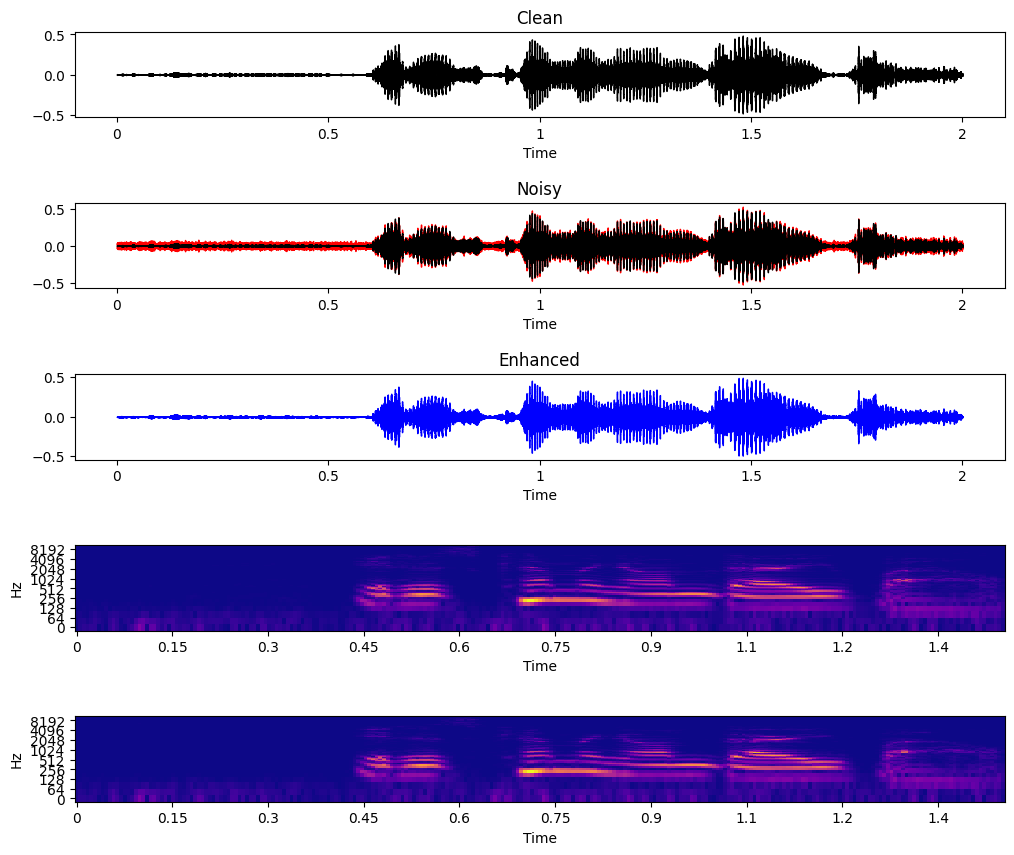

In [ ]:
import matplotlib.pyplot as plt
clean, noisy, enhanced = sf.read('results/clean.wav')[0], sf.read('results/noisy.wav')[0], sf.read('results/enhanced.wav')[0]
fig, axs = plt.subplots(5, figsize=(12,10))
librosa.display.waveshow(clean, sr=16000, ax=axs[0], color='k')
librosa.display.waveshow(noisy, sr=16000, ax=axs[1], color='r')
librosa.display.waveshow(clean, sr=16000, ax=axs[1], color='k')
librosa.display.waveshow(enhanced, sr=16000, ax=axs[2], color='b')
axs[0].set_title('Clean')
axs[1].set_title('Noisy')
axs[2].set_title('Enhanced')
plt.subplots_adjust(hspace=1)

x= librosa.stft(clean, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
y= librosa.stft(enhanced, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
librosa.display.specshow(x, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[3], y_axis='log', x_axis='time', cmap='plasma')
librosa.display.specshow(y, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[4], y_axis='log', x_axis='time', cmap='plasma')
fig.savefig(f'results/waveform.png')


# Exemplul salvat:


## Clean

In [ ]:
import IPython.display as ipd
ipd.Audio(data= 'results/clean.wav', rate=16000)


## Noisy

In [ ]:
ipd.Audio(data= 'results/noisy.wav', rate=16000)


## Denoised

In [ ]:
ipd.Audio(data= 'results/enhanced.wav', rate=16000)


# Test on a longer video

In [ ]:
def testSegment_aux(signal):
  x = signal

  total_samples = len(x)
  total_segments = total_samples // FIXED_LENGTH

  segments = []

  for i in range(total_segments):
      start_sample = i * FIXED_LENGTH
      end_sample = (i + 1) * FIXED_LENGTH
      segment = x[start_sample:end_sample]
      segments.append(segment)

  if total_samples % FIXED_LENGTH != 0:
      start_sample = total_segments * FIXED_LENGTH
      segment = x[start_sample:]
      segments.append(segment)

  last_segment_length = len(segments[-1])
  if last_segment_length < FIXED_LENGTH:
      padding = FIXED_LENGTH - last_segment_length
      segments[-1] = np.concatenate([segments[-1], np.zeros(padding)])

  return segments



In [ ]:
def testSegment_aux2(signal, op):
    segments = testSegment_aux(signal)
    output_dir = op
    print(output_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir[:-1])
    else:
        for file_name in os.listdir(output_dir[:-1]):
              file_path = os.path.join(output_dir[:-1], file_name)
              os.remove(file_path)
    for i in range(len(segments)):
        process_audio(output_file = output_dir + str(i) +'.wav' , signal = segments[i])
    return op

In [52]:
def testSegment(signal, output_dir, file_name):
    testSegment_aux2(signal, output_dir)
    fisieretest = sorted(os.listdir(output_dir), key=lambda x: [int(num) for num in re.findall(r'\d+', x)])
    print(fisieretest)
    fisieretest = [output_dir + x for x in fisieretest]
    data_f = [sf.read(x)[0] for x in fisieretest]
    data_f = np.array(data_f)
    print(data_f.shape)
    data=data_f.flatten()
    sf.write(file_name, data, 16000)
    return data_f


In [53]:
signal = librosa.load('irl7.wav', sr=16000)[0]
segments = testSegment(signal, 'testirl/', 'testirl.wav')

testirl/
['0.wav', '1.wav', '2.wav', '3.wav', '4.wav', '5.wav', '6.wav', '7.wav', '8.wav', '9.wav', '10.wav', '11.wav', '12.wav', '13.wav', '14.wav', '15.wav', '16.wav', '17.wav', '18.wav', '19.wav', '20.wav', '21.wav', '22.wav', '23.wav', '24.wav', '25.wav', '26.wav', '27.wav', '28.wav', '29.wav', '30.wav', '31.wav', '32.wav', '33.wav', '34.wav', '35.wav', '36.wav', '37.wav', '38.wav', '39.wav', '40.wav', '41.wav', '42.wav', '43.wav', '44.wav', '45.wav', '46.wav', '47.wav', '48.wav', '49.wav', '50.wav', '51.wav', '52.wav', '53.wav', '54.wav', '55.wav', '56.wav', '57.wav', '58.wav', '59.wav', '60.wav', '61.wav', '62.wav', '63.wav', '64.wav', '65.wav', '66.wav', '67.wav', '68.wav', '69.wav', '70.wav', '71.wav', '72.wav', '73.wav', '74.wav', '75.wav', '76.wav', '77.wav', '78.wav', '79.wav', '80.wav', '81.wav', '82.wav', '83.wav', '84.wav', '85.wav', '86.wav', '87.wav', '88.wav', '89.wav', '90.wav', '91.wav', '92.wav', '93.wav', '94.wav', '95.wav', '96.wav', '97.wav', '98.wav', '99.wav', 

In [56]:
output_dir = 'testirl/'
for i in range(len(segments)):
    process_audio(output_file = output_dir + str(i) +'.wav' , signal = segments[i])

In [59]:
fisieretest = sorted(os.listdir(output_dir), key=lambda x: [int(num) for num in re.findall(r'\d+', x)])
print(fisieretest)
fisieretest = [output_dir + x for x in fisieretest]
segments = [sf.read(x)[0] for x in fisieretest]
segments = np.array(data)
print(data.shape)
segments=data.flatten()
sf.write('testirl2.wav', segments, samplerate=16000)


['0.wav', '1.wav', '2.wav', '3.wav', '4.wav', '5.wav', '6.wav', '7.wav', '8.wav', '9.wav', '10.wav', '11.wav', '12.wav', '13.wav', '14.wav', '15.wav', '16.wav', '17.wav', '18.wav', '19.wav', '20.wav', '21.wav', '22.wav', '23.wav', '24.wav', '25.wav', '26.wav', '27.wav', '28.wav', '29.wav', '30.wav', '31.wav', '32.wav', '33.wav', '34.wav', '35.wav', '36.wav', '37.wav', '38.wav', '39.wav', '40.wav', '41.wav', '42.wav', '43.wav', '44.wav', '45.wav', '46.wav', '47.wav', '48.wav', '49.wav', '50.wav', '51.wav', '52.wav', '53.wav', '54.wav', '55.wav', '56.wav', '57.wav', '58.wav', '59.wav', '60.wav', '61.wav', '62.wav', '63.wav', '64.wav', '65.wav', '66.wav', '67.wav', '68.wav', '69.wav', '70.wav', '71.wav', '72.wav', '73.wav', '74.wav', '75.wav', '76.wav', '77.wav', '78.wav', '79.wav', '80.wav', '81.wav', '82.wav', '83.wav', '84.wav', '85.wav', '86.wav', '87.wav', '88.wav', '89.wav', '90.wav', '91.wav', '92.wav', '93.wav', '94.wav', '95.wav', '96.wav', '97.wav', '98.wav', '99.wav', '100.wav'

# Exemeplu zgomot natural vechi
[Sursa youtube](https://www.youtube.com/watch?v=meJB-RZvBcY&t)

## Denoised:

In [61]:
# ipd.Audio(data, rate=16000)

# Exemplu zgomot adaugat manual pe sunet clar

[Sursa youtube](https://www.youtube.com/watch?v=VGaf2rsnM4s&t=7s)

In [67]:
signal2 = librosa.load('yttest5.wav', sr=16000)[0] # noise adaugat manual
output_dir = 'yttest/'
segments = testSegment(signal2, output_dir, 'yttest.wav')
fisieretest = sorted(os.listdir(output_dir), key=lambda x: [int(num) for num in re.findall(r'\d+', x)])
for i in range(len(segments)):
    process_audio(output_file = output_dir + str(i) +'.wav' , signal = segments[i])
fisieretest = [output_dir + x for x in fisieretest]
segments = [sf.read(x)[0] for x in fisieretest]
segments = np.array(segments)
segments=segments.flatten()
sf.write('testyt.wav', segments, samplerate=16000)

yttest/
['0.wav', '1.wav', '2.wav', '3.wav', '4.wav', '5.wav', '6.wav', '7.wav', '8.wav', '9.wav', '10.wav', '11.wav', '12.wav', '13.wav', '14.wav', '15.wav', '16.wav', '17.wav', '18.wav', '19.wav', '20.wav', '21.wav', '22.wav', '23.wav', '24.wav', '25.wav', '26.wav', '27.wav', '28.wav', '29.wav', '30.wav', '31.wav', '32.wav', '33.wav', '34.wav', '35.wav', '36.wav', '37.wav', '38.wav', '39.wav', '40.wav', '41.wav', '42.wav', '43.wav', '44.wav', '45.wav', '46.wav', '47.wav', '48.wav', '49.wav', '50.wav', '51.wav', '52.wav', '53.wav', '54.wav', '55.wav', '56.wav', '57.wav', '58.wav', '59.wav', '60.wav', '61.wav', '62.wav', '63.wav', '64.wav', '65.wav', '66.wav', '67.wav', '68.wav', '69.wav', '70.wav', '71.wav', '72.wav', '73.wav', '74.wav', '75.wav', '76.wav', '77.wav', '78.wav', '79.wav', '80.wav', '81.wav', '82.wav', '83.wav', '84.wav', '85.wav', '86.wav', '87.wav', '88.wav', '89.wav', '90.wav', '91.wav', '92.wav', '93.wav', '94.wav', '95.wav', '96.wav', '97.wav', '98.wav', '99.wav', '

## Gaussian noise:

In [74]:
# ipd.Audio(signal2, rate=16000)

## Denoised:

In [70]:
# ipd.Audio('testyt.wav', rate=16000)

# Model 2 using residual blocks

In [76]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.stride != 1 or residual.shape[1] != out.shape[1]:
            residual = F.interpolate(residual, size=out.shape[2:], mode='bilinear', align_corners=False)

        out += residual
        out = self.relu(out)

        return out

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        ### Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 8, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.resblock1 = ResidualBlock(8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.resblock2 = ResidualBlock(16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.resblock3 = ResidualBlock(32, 32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        ### Decoder
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.resblock4 = ResidualBlock(32, 32)
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.resblock5 = ResidualBlock(16, 16)
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.resblock6 = ResidualBlock(8, 8)
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(8, 2, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(2)
        )

        self.convout = nn.Sequential(
            nn.Conv2d(2, 2, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.resblock1(x1)
        x2 = self.conv2(x1)
        x2 = self.resblock2(x2)
        x3 = self.conv3(x2)
        x3 = self.resblock3(x3)
        x4 = self.conv4(x3)

        x5 = self.deconv1(x4) + x3
        x5 = self.resblock4(x5)
        x6 = self.deconv2(x5) + x2
        x6 = self.resblock5(x6)
        x7 = self.deconv3(x6) + x1
        x7 = self.resblock6(x7)
        x8 = self.deconv4(x7)

        mask = self.convout(x8)
        y = mask * x
        return y

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(DEVICE)
torchsummary.summary(model, data[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 127, 127]             152
              ReLU-2          [-1, 8, 127, 127]               0
       BatchNorm2d-3          [-1, 8, 127, 127]              16
            Conv2d-4          [-1, 8, 127, 127]             576
       BatchNorm2d-5          [-1, 8, 127, 127]              16
              ReLU-6          [-1, 8, 127, 127]               0
            Conv2d-7          [-1, 8, 127, 127]             576
       BatchNorm2d-8          [-1, 8, 127, 127]              16
              ReLU-9          [-1, 8, 127, 127]               0
    ResidualBlock-10          [-1, 8, 127, 127]               0
           Conv2d-11           [-1, 16, 63, 63]           1,168
             ReLU-12           [-1, 16, 63, 63]               0
      BatchNorm2d-13           [-1, 16, 63, 63]              32
           Conv2d-14           [-1, 16,

In [ ]:
mse_train = []
mse_test = []
mae_train = []
mae_test = []
train()

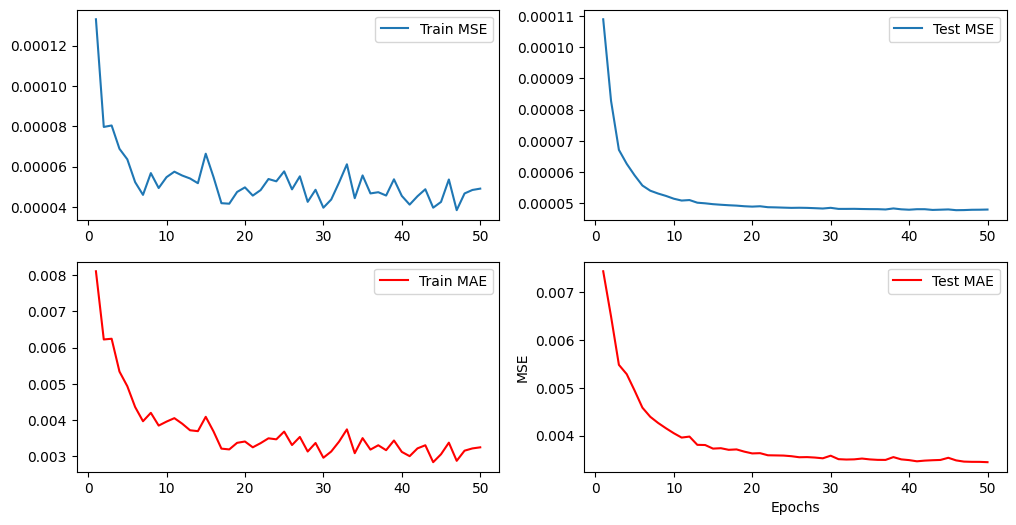

In [78]:
EPOCHS = 50
BATCH_SIZE = 25
if(type(mae_test[1])!=type(0.)):
  mae_test = [tensor.item() for tensor in mae_test]
  mae_train = [tensor.item() for tensor in mae_train]
fig, ax = plt.subplots(2, 2, figsize = (12, 6))
ax[0][0].plot(range(1, EPOCHS + 1), mse_train, label='Train MSE')
ax[0][0].legend()
ax[0][1].plot(range(1, EPOCHS + 1), mse_test, label='Test MSE')
ax[0][1].legend()
ax[1][0].plot(range(1, EPOCHS + 1), mae_train, label='Train MAE', color = 'r')
ax[1][0].legend()
ax[1][1].plot(range(1, EPOCHS + 1), mae_test, label='Test MAE', color = 'r')
ax[1][1].legend()



plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
fig.savefig(f'results/erori.png')



<ipython-input-79-e4f066a82e22>:14: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(x, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[3], y_axis='log', x_axis='time', cmap='plasma')
<ipython-input-79-e4f066a82e22>:15: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(y, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[4], y_axis='log', x_axis='time', cmap='plasma')


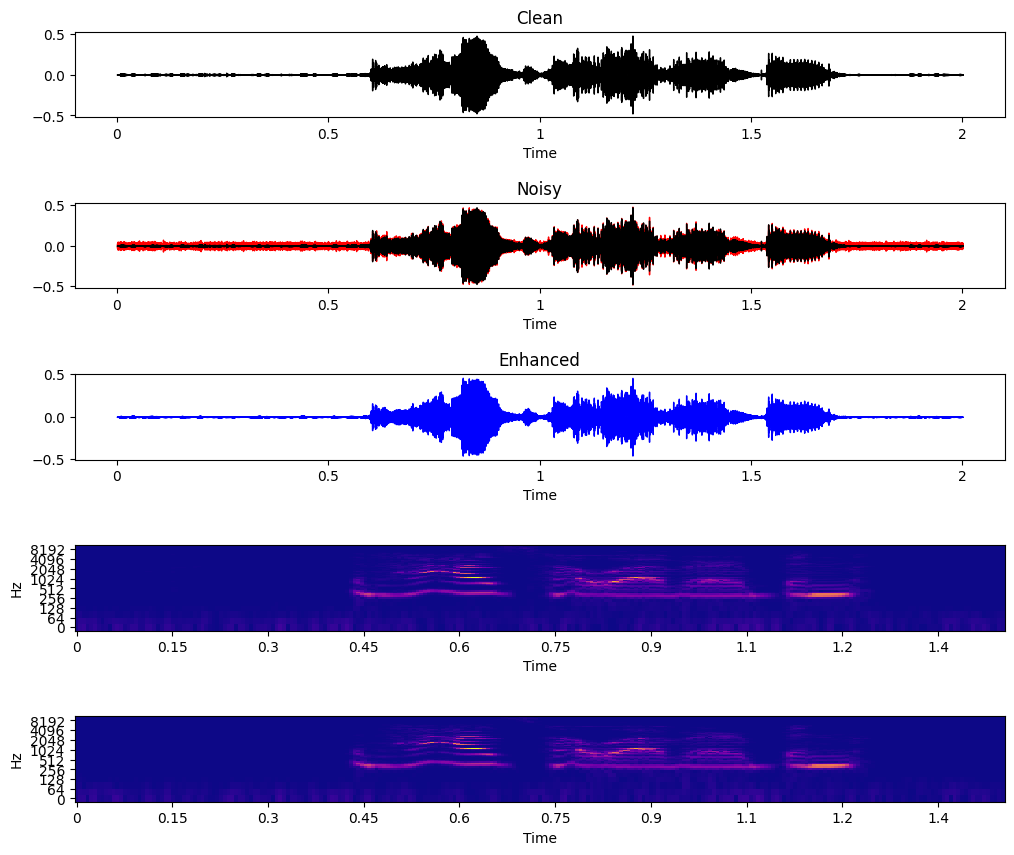

In [79]:
clean, noisy, enhanced = sf.read('results/clean.wav')[0], sf.read('results/noisy.wav')[0], sf.read('results/enhanced.wav')[0]
fig, axs = plt.subplots(5, figsize=(12,10))
librosa.display.waveshow(clean, sr=16000, ax=axs[0], color='k')
librosa.display.waveshow(noisy, sr=16000, ax=axs[1], color='r')
librosa.display.waveshow(clean, sr=16000, ax=axs[1], color='k')
librosa.display.waveshow(enhanced, sr=16000, ax=axs[2], color='b')
axs[0].set_title('Clean')
axs[1].set_title('Noisy')
axs[2].set_title('Enhanced')
plt.subplots_adjust(hspace=1)

x= librosa.stft(clean, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
y= librosa.stft(enhanced, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE)
librosa.display.specshow(x, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[3], y_axis='log', x_axis='time', cmap='plasma')
librosa.display.specshow(y, hop_length=HOP_SIZE, n_fft=FRAME_SIZE, win_length=FRAME_SIZE, ax=axs[4], y_axis='log', x_axis='time', cmap='plasma')
fig.savefig(f'results/waveform.png')

In [81]:
# import os
# import glob

# director = '/content/'

# prefix = 'testirl'

# # Lista fisierelor care încep cu 'testirl'
# file_list = glob.glob(os.path.join(director, prefix + '*'))

# for file_path in file_list:
#     if os.path.isfile(file_path):
#       os.remove(file_path)
#     print(f"Fisierul '{file_path}' a fost sters.")


In [ ]:
# import zipfile
# import os

# folder_path = '/content/results'

# zip_file = '/content/results.zip'

# with zipfile.ZipFile(zip_file, 'w') as zipf:
#     for root, _, files in os.walk(folder_path):
#         for file in files:
#             zipf.write(os.path.join(root, file),
#                        os.path.relpath(os.path.join(root, file),
#                                        os.path.join(folder_path, '..')))

# from google.colab import files
# files.download(zip_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
import gc
gc.collect()

56